In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [2]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	'spread_line',
	'total_line',
]

x_cols = game_context_cols #+ ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'touchdown', 'short_to_first'] # + rusher_stat_cols + ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [189]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,pbp.yards_gained + 40 as yards_shifted,
	case when pbp.down = 1 then 1 else 0 end as is_first_down,
	case when pbp.down = 2 then 1 else 0 end as is_second_down,
	case when pbp.down = 3 then 1 else 0 end as is_third_down,
	case when pbp.down = 4 then 1 else 0 end as is_fourth_down,
	pbp.first_down, pbp.touchdown
    ,rusher_player_name
    ,rusher_id,
                     season,
					 week,
                     fantasy_player_name,
                     qb_scramble,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	--{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	--{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	--{Quack.select_columns(rusher_stat_cols, alias='r', coalesce=True)}
	from pbp 
	--join team_feats as t 
	--on pbp.posteam = t.team
	--and pbp.game_id = t.game_id
	--join opp_feats as o
	--on pbp.defteam = o.opponent_team
	--and pbp.game_id = o.game_id
	--join player_weekly_agg as r
	--on r.game_id = pbp.game_id
	--and pbp.rusher_player_id = r.gsis_id
	--and r.team = pbp.posteam
	where pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
	and pbp.penalty = 0
	and pbp.fumble = 0
""")


X = rushes[x_cols]
y = rushes['yards_shifted']
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
#X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
#y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [13]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	#smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.1)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	#criterion = FocalLoss(gamma=2)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCELoss()
	fd_criterion = nn.BCELoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=0.006)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices].to(device)
	Xtst = X[test_indices].to(device)
	train_y = y[train_indices].to(device)
	#train_y_smooth = smoothed_y[train_indices].to(device)
	test_y =  y[test_indices].to(device)
	#test_y_smooth = smoothed_y[test_indices].to(device)
	train_is_td = (y[train_indices] == (40 +  Xtr[:,0])).float()
	train_is_fd = (y[train_indices] >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]
			#batch_y_smooth =  train_y_smooth[batch_idx]
			batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)


			fd_mask = torch.arange(probs.size(1), device=device).unsqueeze(0) >= (batch_x[:,1] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			fd_output = (probs * fd_mask).sum(1)
			td_mask = torch.arange(probs.size(1),device=device).unsqueeze(0) >= (batch_x[:,0] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			td_output = (probs * td_mask).sum(1)
			td_loss = td_criterion(td_output, batch_td) * 2
			fd_loss = fd_criterion(fd_output, batch_fd) * 0.5

			probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y)
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) 
			loss = classifier_loss + mean_loss + td_loss + fd_loss
			#loss = classifier_loss + td_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()
		n_batches = len(range(0, Xtr.size(0), batch_size))
		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)
			test_loss = criterion(test_preds, test_y).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	return model

In [14]:

rush_yards_model = train_model(X_tensor,y_tensor, n_in=len(x_cols), n_out=140, n_hidden = 128, epochs=10, batch_size=2048)

#Test Loss: 2.3133, Test Accuracy: 0.1709 
#Test Loss: 2.8949, Test Accuracy: 0.1649 add label smoothing, no focal loss
#Test Loss: 2.4887, Test Accuracy: 0.1709 smoothing + focal + remove 1st down leakage
#Test Loss: 2.4681, Test Accuracy: 0.1682 maskedmodel2
#Test Loss: 2.4735, Test Accuracy: 0.1648 hierarchical thing
#Test Loss: 2.4042, Test Accuracy: 0.1596 
#Test Loss: 2.8056, Test Accuracy: 0.1470 fixed td bug, this looks best even w/ low acc. no focal loss or smooth labels

cuda
tensors loading
splitting batches
tensor(0.2378, device='cuda:0')
tensor(0.0326, device='cuda:0')
Epoch 1/10, Classifier Loss: 5.6812, MSE Loss: 46.6607
Test Loss: 3.2644, Test Accuracy: 0.1199
Epoch 2/10, Classifier Loss: 3.0902, MSE Loss: 38.8873
Test Loss: 2.9371, Test Accuracy: 0.1297
Epoch 3/10, Classifier Loss: 2.9499, MSE Loss: 38.8598
Test Loss: 2.9177, Test Accuracy: 0.1235
Epoch 4/10, Classifier Loss: 3.0222, MSE Loss: 38.9217
Test Loss: 2.9817, Test Accuracy: 0.1279
Epoch 5/10, Classifier Loss: 2.9392, MSE Loss: 38.8578
Test Loss: 2.8821, Test Accuracy: 0.1359
Epoch 6/10, Classifier Loss: 2.8894, MSE Loss: 38.8080
Test Loss: 2.8829, Test Accuracy: 0.1356
Epoch 7/10, Classifier Loss: 2.9525, MSE Loss: 38.8725
Test Loss: 3.0541, Test Accuracy: 0.1161
Epoch 8/10, Classifier Loss: 2.9024, MSE Loss: 38.8087
Test Loss: 2.8694, Test Accuracy: 0.1278
Epoch 9/10, Classifier Loss: 2.8777, MSE Loss: 38.8041
Test Loss: 2.9300, Test Accuracy: 0.1250
Epoch 10/10, Classifier Loss: 2.8

In [15]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

true_first=0.09, true_td=0.06
fd_model=0.05, td_model=0.03
Actual mean: 3.50, Model mean: 3.09
number of datapoints: 1361


(-10.0, 32.0)

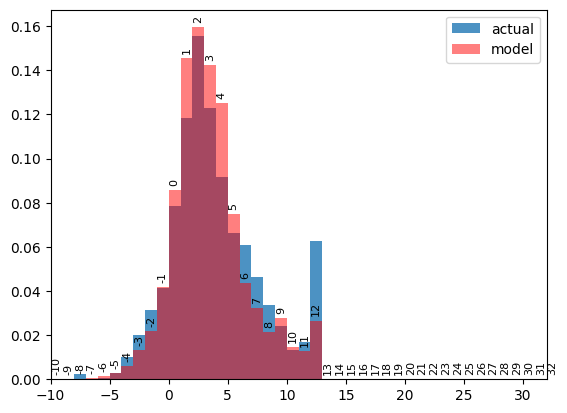

In [104]:
def get_ydl_chance(probs, ydl):

	cols = np.arange(probs.shape[1])
	mask = cols >= ydl[:, None]   # shape (3, 10), True where col >= start
	sums = (probs * mask).sum(axis=1).mean()
	return sums

def sample_model_yardline(yard, down):
	sample = rushes.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	probs = probs.mean(axis=0)
	

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 12
down = 2
probs = sample_model_yardline(yard, down)
plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')
3
# Add index labels on top of bars
for i, p in enumerate(probs):
	yard_val = -40 + i
	if -10 <= yard_val <= yard + 20:  # only label visible range
		plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
				 ha='center', va='bottom', fontsize=8, rotation=90)


plt.legend()
plt.xlim(-10,yard+20)

In [190]:
def sample_model_yardline(yard, down):
	sample = rushes#.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	
	return probs

probs = sample_model_yardline(10,4)
probs

true_first=0.24, true_td=0.03
fd_model=0.22, td_model=0.02


array([[8.55803626e-18, 6.59975306e-19, 7.13832467e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.93716290e-20, 3.86832104e-21, 3.21877948e-20, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.21623240e-18, 1.01341244e-19, 1.02083156e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.19330848e-18, 7.29521731e-20, 1.80734869e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.61764494e-19, 1.03873213e-20, 2.94119189e-19, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.93693439e-17, 4.41756013e-19, 1.63307324e-17, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(350109, 140), dtype=float32)

In [191]:
rushes['pred'] = torch.sum(torch.tensor((probs * np.arange(-40,100))),dim=1)
rushes

,desc,game_id,yards_gained,yards_shifted,is_first_down,is_second_down,is_third_down,is_fourth_down,first_down,touchdown,...,fantasy_player_name,qb_scramble,short_to_first,yardline_100,ydstogo,down,goal_to_go,spread_line,total_line,pred
0,(15:00) T.Jones left end to ARI 37 for 2 yards...,2000_01_ARI_NYG,2.0,42.0,1,0,0,0,0.0,0.0,...,T.Jones,0.0,0,65.0,10.0,1.0,0.0,6.5,40.0,4.101234
1,(13:40) T.Barber right tackle to NYG 30 for 8 ...,2000_01_ARI_NYG,8.0,48.0,1,0,0,0,0.0,0.0,...,T.Barber,0.0,0,78.0,10.0,1.0,0.0,6.5,40.0,4.010535
2,(13:40) R.Dayne right guard to NYG 33 for 3 ya...,2000_01_ARI_NYG,3.0,43.0,0,1,0,0,1.0,0.0,...,R.Dayne,0.0,1,70.0,2.0,2.0,0.0,6.5,40.0,3.688426
3,(13:40) T.Barber left end pushed ob at NYG 32 ...,2000_01_ARI_NYG,-1.0,39.0,1,0,0,0,0.0,0.0,...,T.Barber,0.0,0,67.0,10.0,1.0,0.0,6.5,40.0,4.091104
4,(10:59) R.Dayne right tackle to ARI 39 for 3 y...,2000_01_ARI_NYG,3.0,43.0,0,1,0,0,0.0,0.0,...,R.Dayne,0.0,0,42.0,10.0,2.0,0.0,6.5,40.0,4.416363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350104,(6:46) 29-K.Hunt right guard to KC 19 for 4 ya...,2025_08_WAS_KC,4.0,44.0,1,0,0,0,0.0,0.0,...,K.Hunt,0.0,0,85.0,10.0,1.0,0.0,10.5,48.5,4.313318
350105,(5:31) 29-K.Hunt left tackle to KC 23 for no g...,2025_08_WAS_KC,0.0,40.0,1,0,0,0,0.0,0.0,...,K.Hunt,0.0,0,77.0,10.0,1.0,0.0,10.5,48.5,4.390180
350106,(4:42) (Shotgun) 10-I.Pacheco right guard to K...,2025_08_WAS_KC,1.0,41.0,1,0,0,0,0.0,0.0,...,I.Pacheco,0.0,0,66.0,10.0,1.0,0.0,10.5,48.5,4.336354
350107,(3:55) (Shotgun) 29-K.Hunt left tackle to KC 3...,2025_08_WAS_KC,5.0,45.0,0,1,0,0,0.0,0.0,...,K.Hunt,0.0,0,70.0,14.0,2.0,0.0,10.5,48.5,4.919449


In [193]:
rushes['RYOE'] = rushes['yards_gained'] - rushes['pred']


In [202]:
ex = rushes.loc[rushes.season ==2022].groupby(['rusher_player_name', 'qb_scramble', 'week'])['RYOE'].mean().reset_index().sort_values(by='RYOE')
cnt = rushes.loc[rushes.season == 2022]['rusher_player_name'].value_counts().reset_index()
ex = ex.merge(cnt)
ex.loc[(ex['count'] > 40) & (ex.qb_scramble == 0)].sort_values(by='RYOE').head(30)

,rusher_player_name,qb_scramble,week,RYOE,count
21,M.Breida,0.0,2,-8.294928,60
38,D.Jackson,0.0,8,-7.153225,67
39,D.Ogunbowale,0.0,14,-7.050710,42
53,M.Breida,0.0,6,-5.944393,60
57,D.Jackson,0.0,2,-5.814454,67
59,J.Burrow,0.0,3,-5.761446,62
62,G.Smith,0.0,5,-5.565492,53
63,J.Kelley,0.0,3,-5.560766,76
70,L.Fournette,0.0,4,-5.329591,192
73,T.Lawrence,0.0,1,-5.208567,53


In [206]:
rushes.groupby(['qb_scramble'])[['yards_gained', 'RYOE']].mean()

,yards_gained,RYOE
qb_scramble,,
0.0,4.205826,0.300229
1.0,7.357980,3.098014


In [205]:
ex.loc[ex.rusher_player_name.str.contains('C.McCaff')].sort_values(by='week')

,rusher_player_name,qb_scramble,week,RYOE,count
1069,C.McCaffrey,0.0,1,-0.354761,279
2076,C.McCaffrey,0.0,2,2.964675,279
1315,C.McCaffrey,0.0,3,0.158167,279
831,C.McCaffrey,0.0,4,-0.884594,279
661,C.McCaffrey,0.0,5,-1.331651,279
1630,C.McCaffrey,0.0,6,1.002630,279
1416,C.McCaffrey,0.0,7,0.443742,279
1815,C.McCaffrey,0.0,8,1.642516,279
956,C.McCaffrey,0.0,10,-0.573824,279
1751,C.McCaffrey,0.0,11,1.374286,279
